# Glacier Monitoring Benchmarking Visualization

This notebook provides comprehensive benchmarking analysis for the glacier monitoring algorithm.

## Test Structure:
1. **Cell Processing Time Breakdown** - Pie diagram of processing phases
2. **Cell Size Comparison** - Analysis of different grid sizes (1, 5, 10, 15, 20, 25 km)
3. **Hardware Metrics** - RAM, CPU%, Network, Disk usage
4. **Final Performance Metrics** - Time per km², Time per cell, Total glacier processing time

In [75]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path
import geopandas as gpd

# Set style for better plots
plt.style.use('default')  # Light background for presentations
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# =============================================================================
# CONSISTENT COLOR PALETTE
# =============================================================================
COLORS = {
    # Primary colors for bar charts (gradient for grid sizes)
    'primary': '#2E86AB',      # Steel blue - main data
    'secondary': '#A23B72',    # Magenta - secondary data
    'tertiary': '#F18F01',     # Orange - tertiary data
    
    # Pie chart colors (processing phases)
    'stac_query': '#E63946',   # Red
    'zarr_load': '#2A9D8F',    # Teal
    'ndsi_compute': '#264653', # Dark blue
    'tile_save': '#E9C46A',    # Yellow
    'expansion': '#F4A261',    # Orange
    
    # Hardware metrics
    'ram': '#2E86AB',          # Steel blue
    'cpu': '#2A9D8F',          # Teal
    'network': '#A23B72',      # Magenta
    'disk_read': '#264653',    # Dark blue
    'disk_write': '#F18F01',   # Orange
    'avg_line': '#E63946',     # Red for average lines
    'max_line': '#F4A261',     # Orange for max lines
    
    # Data quality (null rate)
    'good': '#2A9D8F',         # Teal - good (<5%)
    'warning': '#F4A261',      # Orange - warning (5-10%)
    'critical': '#E63946',     # Red - critical (>10%)
}

# Function to get gradient colors for bar charts
def get_bar_colors(n):
    """Generate consistent gradient colors for n bars."""
    return plt.cm.Blues(np.linspace(0.4, 0.9, n))

In [76]:
# =============================================================================
# CONFIGURATION - Set your test run folder here
# =============================================================================

OUTPUT_DIR = Path('output')

# For single test analysis, set the specific test folder
SINGLE_TEST_DIR = OUTPUT_DIR / 'test_monitored_Right_183k'  # Change this to your test folder

# For cell size comparison, define folders for each grid size
# Format: {grid_size_km: 'folder_name'}
CELL_SIZE_TESTS = {
    1: 'test_monitored_Right_1k',
    5: 'test_monitored_Right_5k',
    10: 'test_monitored_Right_10k',
    12: 'test_monitored_Right_12k',
    15: 'test_monitored_Right_15k',
    18.3: 'test_monitored_Right_183k',
    20: 'test_monitored_Right_20k',
    25: 'test_monitored_Right_25k',
}

In [77]:
def load_test_data(test_dir):
    """Load all data from a test directory."""
    test_path = Path(test_dir)
    data = {
        'name': test_path.name,
        'path': test_path,
        'statistics': None,
        'monitoring': None,
        'grid': None
    }
    
    # Load statistics
    stats_files = list(test_path.glob('statistics_*.json'))
    if stats_files:
        with open(stats_files[0], 'r') as f:
            data['statistics'] = json.load(f)
    
    # Load monitoring data
    monitoring_files = list(test_path.glob('proxmox_monitoring_*.json'))
    if monitoring_files:
        with open(monitoring_files[0], 'r') as f:
            data['monitoring'] = json.load(f)
    
    # Load grid
    grid_files = list(test_path.glob('processed_grid_*.geojson'))
    if grid_files:
        data['grid'] = gpd.read_file(grid_files[0])
    
    return data

# Load single test data
test_data = load_test_data(SINGLE_TEST_DIR)
print(f"Loaded test: {test_data['name']}")
print(f"  Statistics: {'✅' if test_data['statistics'] else '❌'}")
print(f"  Monitoring: {'✅' if test_data['monitoring'] else '❌'}")
print(f"  Grid: {'✅' if test_data['grid'] is not None else '❌'}")

Loaded test: test_monitored_Right_183k
  Statistics: ✅
  Monitoring: ✅
  Grid: ✅


---

# 1. Cell Processing Time Breakdown (Pie Diagram)

Shows the time distribution across different processing phases:
- STAC Query
- Zarr Loading
- NDSI Computation
- Tile Saving
- Spatial Expansion

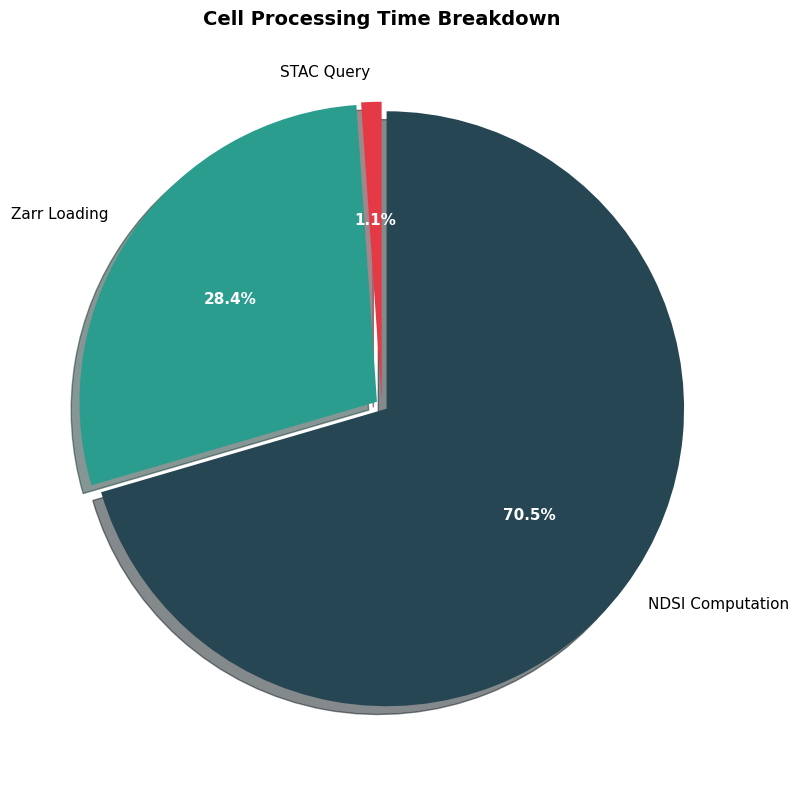


CELL PROCESSING TIME BREAKDOWN

Time distribution:
  STAC query:              1.1%
  Zarr loading:           28.4%
  NDSI computation:       70.4%
  Tile saving:             0.0%
  Spatial expansion:       0.0%


In [78]:
if test_data['statistics'] and 'cell_timing' in test_data['statistics'].get('results', {}):
    timing = test_data['statistics']['results']['cell_timing']
    time_dist = timing.get('time_distribution_percent', {})
    
    # Prepare data for pie chart
    labels = ['STAC Query', 'Zarr Loading', 'NDSI Computation', 'Tile Saving', 'Spatial Expansion']
    sizes = [
        time_dist.get('stac_query', 0),
        time_dist.get('zarr_load', 0),
        time_dist.get('ndsi_compute', 0),
        time_dist.get('tile_save', 0),
        time_dist.get('spatial_expansion', 0)
    ]
    
    # Filter out zero values for cleaner pie chart
    filtered_labels = []
    filtered_sizes = []
    for label, size in zip(labels, sizes):
        if size > 0.1:  # Only show segments > 0.1%
            filtered_labels.append(label)
            filtered_sizes.append(size)
    
    # Consistent pie chart colors
    pie_colors = [COLORS['stac_query'], COLORS['zarr_load'], COLORS['ndsi_compute'], 
                  COLORS['tile_save'], COLORS['expansion']]
    filtered_colors = pie_colors[:len(filtered_labels)]
    
    # Create pie chart
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Pie chart
    wedges, texts, autotexts = ax.pie(
        filtered_sizes, 
        labels=filtered_labels,
        autopct='%1.1f%%',
        colors=filtered_colors,
        explode=[0.02] * len(filtered_sizes),
        shadow=True,
        startangle=90
    )
    ax.set_title('Cell Processing Time Breakdown', fontsize=14, fontweight='bold')
    
    # Make percentage labels more visible
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print text summary
    print("\n" + "=" * 60)
    print("CELL PROCESSING TIME BREAKDOWN")
    print("=" * 60)
    print(f"\nTime distribution:")
    print(f"  STAC query:           {time_dist.get('stac_query', 0):>6.1f}%")
    print(f"  Zarr loading:         {time_dist.get('zarr_load', 0):>6.1f}%")
    print(f"  NDSI computation:     {time_dist.get('ndsi_compute', 0):>6.1f}%")
    print(f"  Tile saving:          {time_dist.get('tile_save', 0):>6.1f}%")
    print(f"  Spatial expansion:    {time_dist.get('spatial_expansion', 0):>6.1f}%")
else:
    print("❌ No cell timing data available in statistics.")

---

# 2. Cell Size Comparison

Compare processing performance across different grid cell sizes:
- 1 km, 5 km, 10 km, 15 km, 20 km, 25 km

Shows:
- Processing time
- Number of cells
- Result grid visualization

In [79]:
# Load all cell size test data
cell_size_data = {}

for size_km, folder_name in CELL_SIZE_TESTS.items():
    folder_path = OUTPUT_DIR / folder_name
    if folder_path.exists():
        cell_size_data[size_km] = load_test_data(folder_path)
        print(f"✅ Loaded {size_km}km test from '{folder_name}'")
    else:
        print(f"❌ Folder not found: {folder_path}")

print(f"\nLoaded {len(cell_size_data)} cell size tests")

✅ Loaded 1km test from 'test_monitored_Right_1k'
✅ Loaded 5km test from 'test_monitored_Right_5k'
✅ Loaded 10km test from 'test_monitored_Right_10k'
✅ Loaded 12km test from 'test_monitored_Right_12k'
✅ Loaded 15km test from 'test_monitored_Right_15k'
✅ Loaded 18.3km test from 'test_monitored_Right_183k'
✅ Loaded 20km test from 'test_monitored_Right_20k'
✅ Loaded 25km test from 'test_monitored_Right_25k'

Loaded 8 cell size tests



CELL SIZE COMPARISON


,Grid Size (km),Grid Size (m),Cells Processed,Total Time (s),Avg Time/Cell (s),Snow/Ice km²,Snow %,Null Rate (%)
0,1.0,1000,675,24233.74,32.917,483.6250,89.799201,7.912688
1,5.0,5000,45,1741.41,35.427,497.9972,70.972822,8.163265
2,10.0,10000,20,825.44,39.189,503.5541,54.974992,4.761905
3,12.0,12000,17,775.00,45.469,507.6755,53.288210,0.000000
4,15.0,15000,16,776.23,48.391,513.5569,43.355905,0.000000
5,18.3,18300,10,496.56,49.527,522.9388,41.500260,0.000000
6,20.0,20000,10,498.22,49.681,510.5283,36.817475,0.000000
7,25.0,25000,8,447.10,55.740,532.5562,34.063274,0.000000


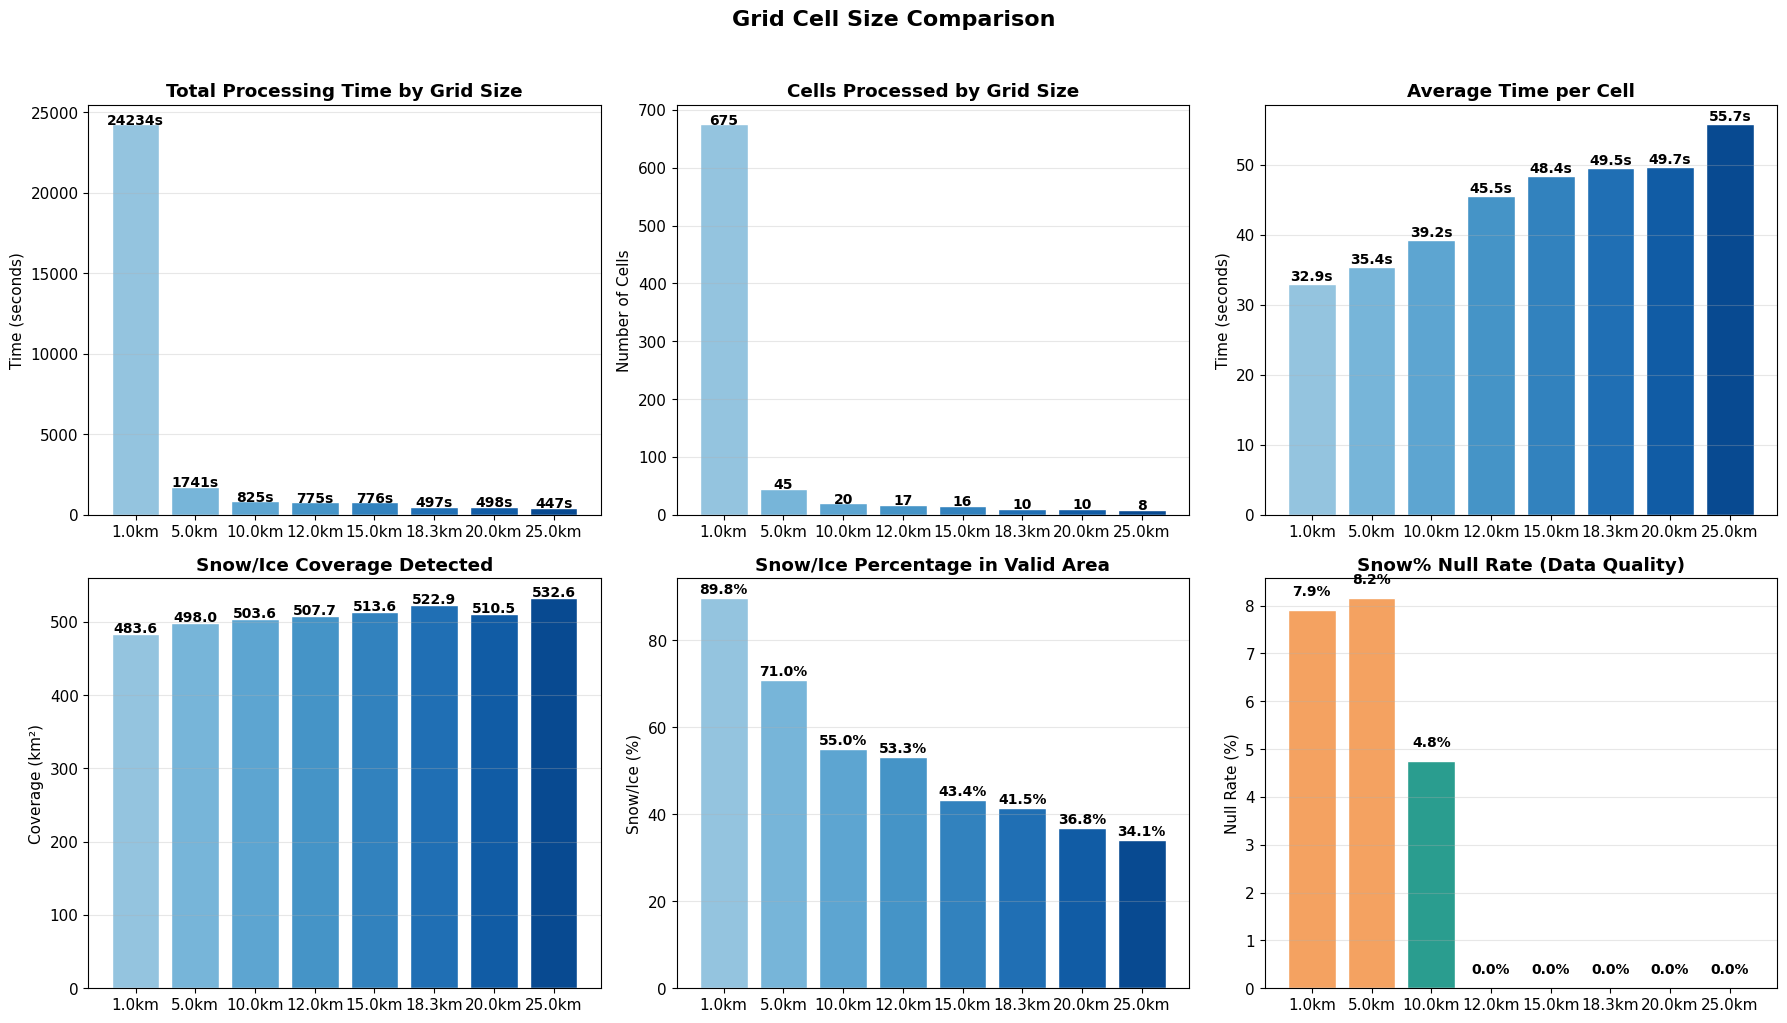

In [80]:
if len(cell_size_data) >= 1:
    # Prepare comparison data
    comparison = []
    for size_km, data in sorted(cell_size_data.items()):
        if data['statistics']:
            stats = data['statistics']
            config = stats.get('configuration', {})
            results = stats.get('results', {})
            timing = results.get('cell_timing', {})
            
            # Calculate snow_percentage null rate from grid
            null_rate = 0.0
            if data['grid'] is not None:
                grid = data['grid']
                processed = grid[grid['is_processed'] == True]
                if len(processed) > 0 and 'snow_percentage' in processed.columns:
                    null_count = processed['snow_percentage'].isna().sum()
                    null_rate = 100 * null_count / len(processed)
            
            comparison.append({
                'Grid Size (km)': size_km,
                'Grid Size (m)': config.get('grid_size', size_km * 1000),
                'Cells Processed': results.get('total_cells_processed', 0),
                'Total Time (s)': results.get('processing_time_seconds', 0),
                'Avg Time/Cell (s)': timing.get('average_times_per_cell', {}).get('total_seconds', 0),
                'Snow/Ice km²': results.get('snow_ice_coverage_km2', 0),
                'Snow %': results.get('snow_ice_percentage', 0),
                'Null Rate (%)': null_rate,
            })
    
    if comparison:
        comp_df = pd.DataFrame(comparison)
        print("\n" + "=" * 80)
        print("CELL SIZE COMPARISON")
        print("=" * 80)
        display(comp_df)
        
        # Visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        sizes = comp_df['Grid Size (km)'].values
        colors = get_bar_colors(len(sizes))
        
        # Total Processing Time
        ax1 = axes[0, 0]
        bars1 = ax1.bar([f"{s}km" for s in sizes], comp_df['Total Time (s)'], color=colors, edgecolor='white')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Total Processing Time by Grid Size', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars1, comp_df['Total Time (s)']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{val:.0f}s', ha='center', fontsize=10, fontweight='bold')
        
        # Number of Cells
        ax2 = axes[0, 1]
        bars2 = ax2.bar([f"{s}km" for s in sizes], comp_df['Cells Processed'], color=colors, edgecolor='white')
        ax2.set_ylabel('Number of Cells')
        ax2.set_title('Cells Processed by Grid Size', fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars2, comp_df['Cells Processed']):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                    str(int(val)), ha='center', fontsize=10, fontweight='bold')
        
        # Time per Cell
        ax3 = axes[0, 2]
        bars3 = ax3.bar([f"{s}km" for s in sizes], comp_df['Avg Time/Cell (s)'], color=colors, edgecolor='white')
        ax3.set_ylabel('Time (seconds)')
        ax3.set_title('Average Time per Cell', fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars3, comp_df['Avg Time/Cell (s)']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{val:.1f}s', ha='center', fontsize=10, fontweight='bold')
        
        # Snow Coverage
        ax4 = axes[1, 0]
        bars4 = ax4.bar([f"{s}km" for s in sizes], comp_df['Snow/Ice km²'], color=colors, edgecolor='white')
        ax4.set_ylabel('Coverage (km²)')
        ax4.set_title('Snow/Ice Coverage Detected', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars4, comp_df['Snow/Ice km²']):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{val:.1f}', ha='center', fontsize=10, fontweight='bold')
        
        # Snow Percentage
        ax5 = axes[1, 1]
        bars5 = ax5.bar([f"{s}km" for s in sizes], comp_df['Snow %'], color=colors, edgecolor='white')
        ax5.set_ylabel('Snow/Ice (%)')
        ax5.set_title('Snow/Ice Percentage in Valid Area', fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars5, comp_df['Snow %']):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')
        
        # Null Rate (Data Quality)
        ax6 = axes[1, 2]
        null_colors = [COLORS['critical'] if v > 10 else COLORS['warning'] if v > 5 else COLORS['good'] for v in comp_df['Null Rate (%)']]
        bars6 = ax6.bar([f"{s}km" for s in sizes], comp_df['Null Rate (%)'], color=null_colors, edgecolor='white')
        ax6.set_ylabel('Null Rate (%)')
        ax6.set_title('Snow% Null Rate (Data Quality)', fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars6, comp_df['Null Rate (%)']):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                    f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')
        
        plt.suptitle('Grid Cell Size Comparison', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
else:
    print("\n⚠️ Not enough cell size test data for comparison.")
    print("Run tests with different grid sizes and update CELL_SIZE_TESTS configuration.")

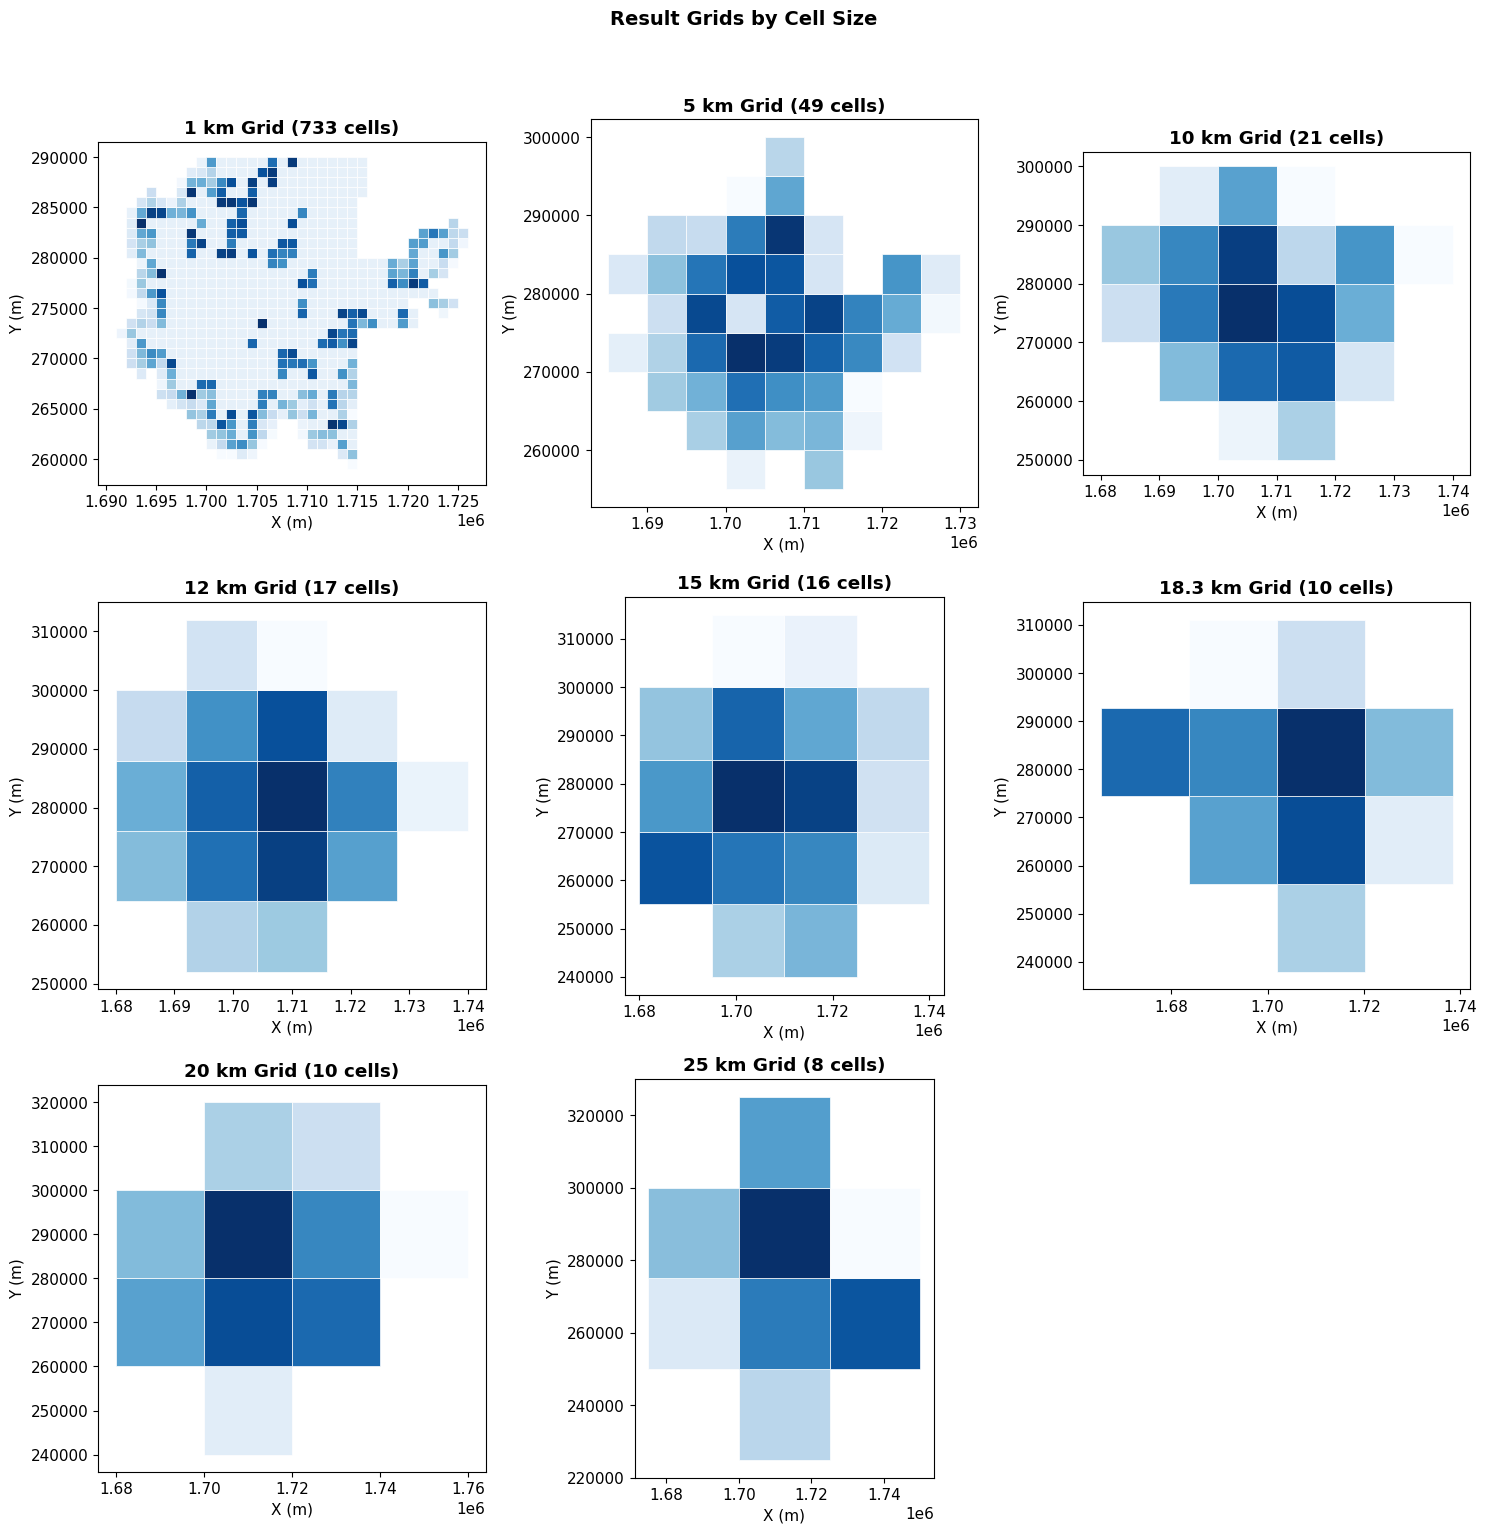

In [81]:
# Visualize result grids for each cell size
grids_to_show = [(size, data) for size, data in sorted(cell_size_data.items()) if data['grid'] is not None]

if grids_to_show:
    n_grids = len(grids_to_show)
    cols = min(3, n_grids)
    rows = (n_grids + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if n_grids == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    for idx, (size_km, data) in enumerate(grids_to_show):
        ax = axes[idx]
        grid = data['grid']
        
        # Plot grid with snow percentage coloring (no legend)
        processed = grid[grid['is_processed'] == True]
        if 'snow_percentage' in processed.columns and not processed['snow_percentage'].isna().all():
            processed.plot(column='snow_percentage', ax=ax, legend=False, 
                          cmap='Blues', edgecolor='white', linewidth=0.5)
        else:
            processed.plot(ax=ax, color='#4ecdc4', edgecolor='white', linewidth=0.5)
        
        ax.set_title(f'{size_km} km Grid ({len(processed)} cells)', fontweight='bold')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
    
    # Hide empty subplots
    for idx in range(len(grids_to_show), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Result Grids by Cell Size', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No grid data available for visualization.")

---

# 3. Hardware Metrics

Analyze hardware resource usage:
- RAM Usage
- CPU Utilization (%)
- Network Transfer
- Disk I/O

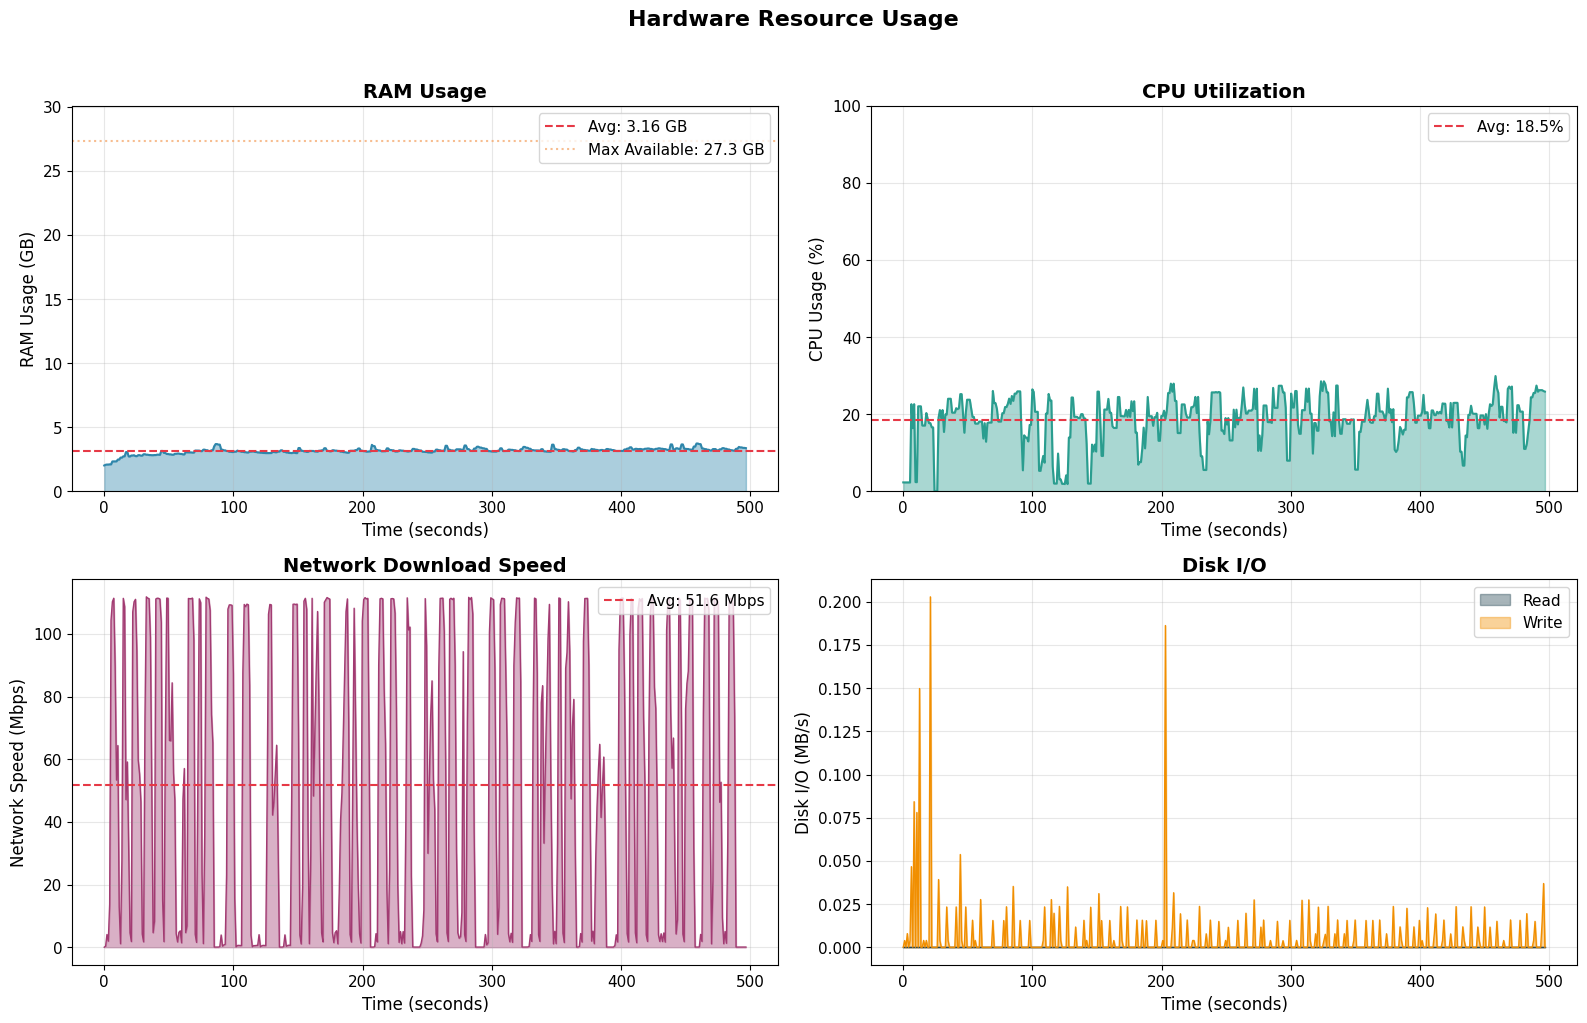


HARDWARE METRICS SUMMARY

💾 RAM:
   Min:  2.01 GB
   Max:  3.72 GB
   Avg:  3.16 GB
   Total: 27.3 GB

🖥️ CPU:
   Min:  0.0%
   Max:  29.9%
   Avg:  18.5%

🌐 Network:
   Downloaded: 3055.3 MB
   Avg Speed:  51.6 Mbps
   Peak Speed: 111.8 Mbps

💿 Disk:
   Read:    0.0 MB
   Written: 2.5 MB


In [82]:
if test_data['monitoring']:
    mon = test_data['monitoring']
    samples = pd.DataFrame(mon['samples'])
    samples['elapsed_seconds'] = samples['time'] - samples['time'].iloc[0]
    
    # Calculate derived metrics
    samples['mem_gb'] = samples['mem'] / (1024**3)
    samples['maxmem_gb'] = samples['maxmem'] / (1024**3)
    samples['netin_rate'] = samples['netin'].diff() / samples['time'].diff()
    samples['netin_mbps'] = samples['netin_rate'] * 8 / 1e6
    samples['diskread_rate'] = samples['diskread'].diff() / samples['time'].diff() / 1e6
    samples['diskwrite_rate'] = samples['diskwrite'].diff() / samples['time'].diff() / 1e6
    samples = samples.fillna(0)
    
    # Create 2x2 hardware metrics dashboard
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # RAM Usage
    ax1 = axes[0, 0]
    ax1.fill_between(samples['elapsed_seconds'], samples['mem_gb'], alpha=0.4, color=COLORS['ram'])
    ax1.plot(samples['elapsed_seconds'], samples['mem_gb'], color=COLORS['ram'], linewidth=1.5)
    ax1.axhline(y=samples['mem_gb'].mean(), color=COLORS['avg_line'], linestyle='--', 
                label=f"Avg: {samples['mem_gb'].mean():.2f} GB")
    ax1.axhline(y=samples['maxmem_gb'].iloc[0], color=COLORS['max_line'], linestyle=':', alpha=0.7,
                label=f"Max Available: {samples['maxmem_gb'].iloc[0]:.1f} GB")
    ax1.set_ylabel('RAM Usage (GB)', fontsize=12)
    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_title('RAM Usage', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, samples['maxmem_gb'].iloc[0] * 1.1)
    
    # CPU %
    ax2 = axes[0, 1]
    ax2.fill_between(samples['elapsed_seconds'], samples['cpu_percent'], alpha=0.4, color=COLORS['cpu'])
    ax2.plot(samples['elapsed_seconds'], samples['cpu_percent'], color=COLORS['cpu'], linewidth=1.5)
    ax2.axhline(y=mon['cpu_stats']['avg_percent'], color=COLORS['avg_line'], linestyle='--',
                label=f"Avg: {mon['cpu_stats']['avg_percent']:.1f}%")
    ax2.set_ylabel('CPU Usage (%)', fontsize=12)
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_title('CPU Utilization', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, max(100, samples['cpu_percent'].max() * 1.1))
    
    # Network
    ax3 = axes[1, 0]
    ax3.fill_between(samples['elapsed_seconds'], samples['netin_mbps'], alpha=0.4, color=COLORS['network'])
    ax3.plot(samples['elapsed_seconds'], samples['netin_mbps'], color=COLORS['network'], linewidth=1)
    ax3.axhline(y=mon['network_transfer']['avg_speed_mbps_in'], color=COLORS['avg_line'], linestyle='--',
                label=f"Avg: {mon['network_transfer']['avg_speed_mbps_in']:.1f} Mbps")
    ax3.set_ylabel('Network Speed (Mbps)', fontsize=12)
    ax3.set_xlabel('Time (seconds)', fontsize=12)
    ax3.set_title('Network Download Speed', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # Disk I/O
    ax4 = axes[1, 1]
    ax4.fill_between(samples['elapsed_seconds'], samples['diskread_rate'], alpha=0.4, color=COLORS['disk_read'], label='Read')
    ax4.fill_between(samples['elapsed_seconds'], samples['diskwrite_rate'], alpha=0.4, color=COLORS['disk_write'], label='Write')
    ax4.plot(samples['elapsed_seconds'], samples['diskread_rate'], color=COLORS['disk_read'], linewidth=1)
    ax4.plot(samples['elapsed_seconds'], samples['diskwrite_rate'], color=COLORS['disk_write'], linewidth=1)
    ax4.set_ylabel('Disk I/O (MB/s)', fontsize=12)
    ax4.set_xlabel('Time (seconds)', fontsize=12)
    ax4.set_title('Disk I/O', fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Hardware Resource Usage', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "=" * 60)
    print("HARDWARE METRICS SUMMARY")
    print("=" * 60)
    print(f"\n💾 RAM:")
    print(f"   Min:  {samples['mem_gb'].min():.2f} GB")
    print(f"   Max:  {samples['mem_gb'].max():.2f} GB")
    print(f"   Avg:  {samples['mem_gb'].mean():.2f} GB")
    print(f"   Total: {samples['maxmem_gb'].iloc[0]:.1f} GB")
    
    print(f"\n🖥️ CPU:")
    print(f"   Min:  {mon['cpu_stats']['min_percent']:.1f}%")
    print(f"   Max:  {mon['cpu_stats']['max_percent']:.1f}%")
    print(f"   Avg:  {mon['cpu_stats']['avg_percent']:.1f}%")
    
    print(f"\n🌐 Network:")
    print(f"   Downloaded: {mon['network_transfer']['mb_in']:.1f} MB")
    print(f"   Avg Speed:  {mon['network_transfer']['avg_speed_mbps_in']:.1f} Mbps")
    print(f"   Peak Speed: {samples['netin_mbps'].max():.1f} Mbps")
    
    print(f"\n💿 Disk:")
    print(f"   Read:    {mon['disk_io']['mb_read']:.1f} MB")
    print(f"   Written: {mon['disk_io']['mb_written']:.1f} MB")
else:
    print("❌ No monitoring data available. Run with --proxmox flag to collect hardware metrics.")

---

# 4. Final Performance Metrics (Bar Charts)

Key performance indicators:
- **Time per km²** - Processing efficiency
- **Time per Cell (avg)** - Cell processing speed
- **Total Glacier Area Processing Time** - End-to-end performance

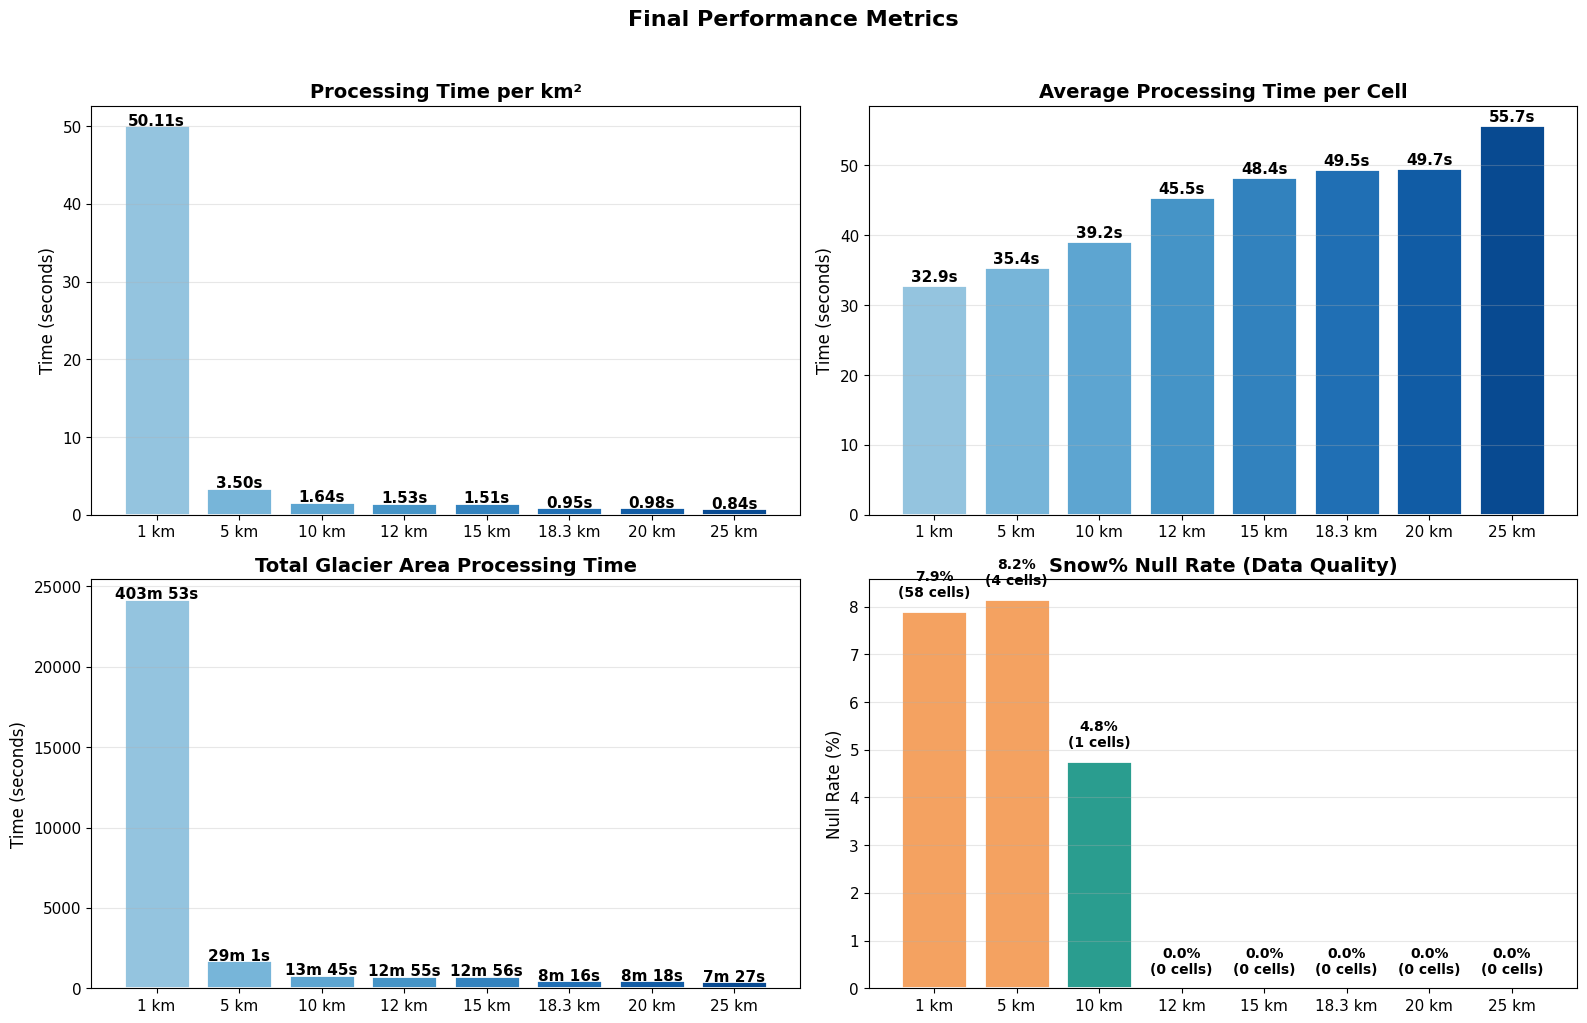


FINAL PERFORMANCE METRICS


,Grid Size,Time per km² (s),Avg Time per Cell (s),Total Processing Time (s),Glacier Area (km²),Cells Processed,Null Count,Null Rate (%)
0,1 km,50.108535,32.917,24233.74,483.6250,675,58,7.912688
1,5 km,3.496827,35.427,1741.41,497.9972,45,4,8.163265
2,10 km,1.639228,39.189,825.44,503.5541,20,1,4.761905
3,12 km,1.526566,45.469,775.00,507.6755,17,0,0.000000
4,15 km,1.511478,48.391,776.23,513.5569,16,0,0.000000
5,18.3 km,0.949557,49.527,496.56,522.9388,10,0,0.000000
6,20 km,0.975891,49.681,498.22,510.5283,10,0,0.000000
7,25 km,0.839536,55.740,447.10,532.5562,8,0,0.000000


In [83]:
# Calculate final metrics from all available tests
final_metrics = []

for size_km, data in sorted(cell_size_data.items()):
    if data['statistics']:
        stats = data['statistics']
        results = stats.get('results', {})
        timing = results.get('cell_timing', {})
        
        total_time = results.get('processing_time_seconds', 0)
        cells = results.get('total_cells_processed', 0)
        coverage_km2 = results.get('snow_ice_coverage_km2', 0)
        valid_area_km2 = results.get('total_valid_area_km2', 0)
        
        # Calculate metrics
        time_per_km2 = total_time / coverage_km2 if coverage_km2 > 0 else 0
        time_per_cell = timing.get('average_times_per_cell', {}).get('total_seconds', 
                                   total_time / cells if cells > 0 else 0)
        
        # Calculate null rate from grid
        null_rate = 0.0
        null_count = 0
        total_processed = 0
        if data['grid'] is not None:
            grid = data['grid']
            processed = grid[grid['is_processed'] == True]
            total_processed = len(processed)
            if total_processed > 0 and 'snow_percentage' in processed.columns:
                null_count = int(processed['snow_percentage'].isna().sum())
                null_rate = 100 * null_count / total_processed
        
        final_metrics.append({
            'Grid Size': f'{size_km} km',
            'Grid Size (km)': size_km,
            'Time per km² (s)': time_per_km2,
            'Avg Time per Cell (s)': time_per_cell,
            'Total Processing Time (s)': total_time,
            'Glacier Area (km²)': coverage_km2,
            'Cells Processed': cells,
            'Null Count': null_count,
            'Null Rate (%)': null_rate
        })

if final_metrics:
    metrics_df = pd.DataFrame(final_metrics)
    
    # Create bar charts
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    sizes = metrics_df['Grid Size'].values
    colors = get_bar_colors(len(sizes))
    
    # Time per km²
    ax1 = axes[0, 0]
    bars1 = ax1.bar(sizes, metrics_df['Time per km² (s)'], color=colors, edgecolor='white', linewidth=2)
    ax1.set_ylabel('Time (seconds)', fontsize=12)
    ax1.set_title('Processing Time per km²', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars1, metrics_df['Time per km² (s)']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')
    
    # Avg Time per Cell
    ax2 = axes[0, 1]
    bars2 = ax2.bar(sizes, metrics_df['Avg Time per Cell (s)'], color=colors, edgecolor='white', linewidth=2)
    ax2.set_ylabel('Time (seconds)', fontsize=12)
    ax2.set_title('Average Processing Time per Cell', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars2, metrics_df['Avg Time per Cell (s)']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}s', ha='center', fontsize=11, fontweight='bold')
    
    # Total Processing Time for Glacier Area
    ax3 = axes[1, 0]
    bars3 = ax3.bar(sizes, metrics_df['Total Processing Time (s)'], color=colors, edgecolor='white', linewidth=2)
    ax3.set_ylabel('Time (seconds)', fontsize=12)
    ax3.set_title('Total Glacier Area Processing Time', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars3, metrics_df['Total Processing Time (s)']):
        mins = int(val // 60)
        secs = int(val % 60)
        label = f'{mins}m {secs}s' if mins > 0 else f'{val:.0f}s'
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                label, ha='center', fontsize=11, fontweight='bold')
    
    # Null Rate (Data Quality)
    ax4 = axes[1, 1]
    null_colors = [COLORS['critical'] if v > 10 else COLORS['warning'] if v > 5 else COLORS['good'] for v in metrics_df['Null Rate (%)']]
    bars4 = ax4.bar(sizes, metrics_df['Null Rate (%)'], color=null_colors, edgecolor='white', linewidth=2)
    ax4.set_ylabel('Null Rate (%)', fontsize=12)
    ax4.set_title('Snow% Null Rate (Data Quality)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    for bar, val, cnt in zip(bars4, metrics_df['Null Rate (%)'], metrics_df['Null Count']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                f'{val:.1f}%\n({int(cnt)} cells)', ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Final Performance Metrics', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "=" * 80)
    print("FINAL PERFORMANCE METRICS")
    print("=" * 80)
    display(metrics_df[['Grid Size', 'Time per km² (s)', 'Avg Time per Cell (s)', 
                        'Total Processing Time (s)', 'Glacier Area (km²)', 'Cells Processed',
                        'Null Count', 'Null Rate (%)']])
else:
    print("❌ No statistics data available for final metrics.")

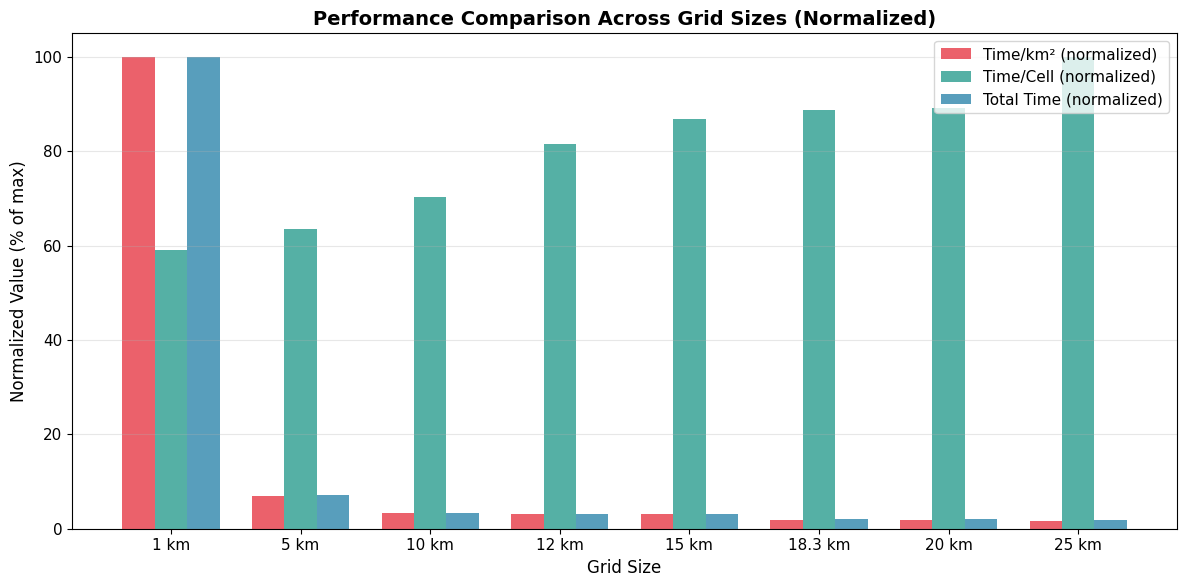

In [84]:
# Combined efficiency visualization
if final_metrics and len(final_metrics) > 1:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(sizes))
    width = 0.25
    
    # Normalize values for comparison (scale to 0-100)
    max_time_km2 = max(m['Time per km² (s)'] for m in final_metrics)
    max_time_cell = max(m['Avg Time per Cell (s)'] for m in final_metrics)
    max_total = max(m['Total Processing Time (s)'] for m in final_metrics)
    
    time_km2_norm = [100 * m['Time per km² (s)'] / max_time_km2 for m in final_metrics]
    time_cell_norm = [100 * m['Avg Time per Cell (s)'] / max_time_cell for m in final_metrics]
    total_norm = [100 * m['Total Processing Time (s)'] / max_total for m in final_metrics]
    
    # Use consistent colors from palette
    bars1 = ax.bar(x - width, time_km2_norm, width, label='Time/km² (normalized)', color=COLORS['stac_query'], alpha=0.8)
    bars2 = ax.bar(x, time_cell_norm, width, label='Time/Cell (normalized)', color=COLORS['zarr_load'], alpha=0.8)
    bars3 = ax.bar(x + width, total_norm, width, label='Total Time (normalized)', color=COLORS['primary'], alpha=0.8)
    
    ax.set_ylabel('Normalized Value (% of max)', fontsize=12)
    ax.set_xlabel('Grid Size', fontsize=12)
    ax.set_title('Performance Comparison Across Grid Sizes (Normalized)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(sizes)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
elif final_metrics:
    print("ℹ️ Only one grid size available. Run more tests to enable comparison chart.")

---

# Summary Report

In [85]:
print("=" * 80)
print("BENCHMARKING SUMMARY REPORT")
print("=" * 80)

if test_data['statistics']:
    stats = test_data['statistics']
    results = stats.get('results', {})
    config = stats.get('configuration', {})
    timing = results.get('cell_timing', {})
    
    print(f"\n📋 Test Configuration:")
    print(f"   Grid Size: {config.get('grid_size', 'N/A')/1000:.0f} km")
    print(f"   Date Range: {config.get('date_start')} to {config.get('date_end')}")
    print(f"   NDSI Threshold: {config.get('ndsi_threshold')}")
    print(f"   Snow Expansion Threshold: {config.get('snow_percentage_threshold')*100:.0f}%")
    print(f"   Low Memory Mode: {config.get('low_memory', False)}")
    
    print(f"\n📊 Processing Results:")
    print(f"   Cells Processed: {results.get('total_cells_processed', 'N/A')}")
    print(f"   Iterations: {results.get('iterations', 'N/A')}")
    print(f"   Total Time: {results.get('processing_time_formatted', 'N/A')}")
    
    print(f"\n🏔️ Coverage Results:")
    print(f"   Snow/Ice Coverage: {results.get('snow_ice_coverage_km2', 0):.2f} km²")
    print(f"   Valid Area Analyzed: {results.get('total_valid_area_km2', 0):.2f} km²")
    print(f"   Snow/Ice Percentage: {results.get('snow_ice_percentage', 0):.1f}%")
    
    # Calculate null rate from grid
    if test_data['grid'] is not None:
        grid = test_data['grid']
        processed = grid[grid['is_processed'] == True]
        if len(processed) > 0 and 'snow_percentage' in processed.columns:
            null_count = int(processed['snow_percentage'].isna().sum())
            null_rate = 100 * null_count / len(processed)
            print(f"\n⚠️ Data Quality:")
            print(f"   Cells with null snow%: {null_count} / {len(processed)}")
            print(f"   Null Rate: {null_rate:.2f}%")
            if null_rate > 10:
                print(f"   Status: ❌ CRITICAL - Many cells missing data")
            elif null_rate > 5:
                print(f"   Status: ⚠️ WARNING - Some cells missing data")
            else:
                print(f"   Status: ✅ GOOD - Most cells have valid data")
    
    print(f"\n⏱️ Time Breakdown:")
    time_dist = timing.get('time_distribution_percent', {})
    print(f"   STAC Query:       {time_dist.get('stac_query', 0):>5.1f}%")
    print(f"   Zarr Loading:     {time_dist.get('zarr_load', 0):>5.1f}%")
    print(f"   NDSI Computation: {time_dist.get('ndsi_compute', 0):>5.1f}%")
    print(f"   Tile Saving:      {time_dist.get('tile_save', 0):>5.1f}%")
    print(f"   Expansion:        {time_dist.get('spatial_expansion', 0):>5.1f}%")

if test_data['monitoring']:
    mon = test_data['monitoring']
    print(f"\n💻 Hardware Usage:")
    print(f"   CPU Avg: {mon['cpu_stats']['avg_percent']:.1f}% (Max: {mon['cpu_stats']['max_percent']:.1f}%)")
    samples_df = pd.DataFrame(mon['samples'])
    mem_avg = samples_df['mem'].mean() / (1024**3)
    mem_max = samples_df['mem'].max() / (1024**3)
    print(f"   RAM Avg: {mem_avg:.2f} GB (Max: {mem_max:.2f} GB)")
    print(f"   Network: {mon['network_transfer']['mb_in']:.1f} MB downloaded")
    print(f"   Disk: {mon['disk_io']['mb_written']:.1f} MB written")

print("\n" + "=" * 80)

BENCHMARKING SUMMARY REPORT

📋 Test Configuration:
   Grid Size: 18 km
   Date Range: 2025-07-01 to 2025-07-31
   NDSI Threshold: 0.42
   Snow Expansion Threshold: 30%
   Low Memory Mode: False

📊 Processing Results:
   Cells Processed: 10
   Iterations: 4
   Total Time: 8m 16s

🏔️ Coverage Results:
   Snow/Ice Coverage: 522.94 km²
   Valid Area Analyzed: 1260.09 km²
   Snow/Ice Percentage: 41.5%

⚠️ Data Quality:
   Cells with null snow%: 0 / 10
   Null Rate: 0.00%
   Status: ✅ GOOD - Most cells have valid data

⏱️ Time Breakdown:
   STAC Query:         1.1%
   Zarr Loading:      28.4%
   NDSI Computation:  70.4%
   Tile Saving:        0.0%
   Expansion:          0.0%

💻 Hardware Usage:
   CPU Avg: 18.5% (Max: 29.9%)
   RAM Avg: 3.16 GB (Max: 3.72 GB)
   Network: 3055.3 MB downloaded
   Disk: 2.5 MB written

